In [54]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="whitegrid")

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

SEED = 1

In [47]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False, ylim=[0,1.1], title='Validation Curve', ax=None):    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)

    lw = 2
    
    if ax == None: 
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.ylim(ylim)
        if x_logscale:
            plt.semilogx(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        else:
            plt.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)

        plt.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        if x_logscale:
            plt.semilogx(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        else:
            plt.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)

        plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        plt.legend(loc='best')
    else:
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_ylim(ylim)
        if x_logscale:
            ax.semilogx(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        else:
            ax.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)

        ax.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        if x_logscale:
            ax.semilogx(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        else:
            ax.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)

        ax.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        ax.legend(loc="best")

In [52]:
def plot_confusion_matrix(cm, title='Confusion Matrix', ax=None):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    sns.heatmap(data=pd.DataFrame(cm), vmin=0, annot=True, square=True, cmap=plt.cm.Reds, fmt='g', ax=ax)
    if ax == None:
        plt.xlabel('Predicted label')
        plt.ylabel('Actual label')
        plt.title(title)
    else:
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('Actual label')
        ax.set_title(title)

In [2]:
df_well_being_raw = pd.read_excel("data/london-ward-well-being-probability-scores.xls", sheet_name="Dashboard", skiprows=12)
df_grocery_raw = pd.read_csv('data/year_osward_grocery.csv')

In [24]:
df_well_being_raw.head()

,Borough name,Ward Code,Ward name,Unnamed: 3,Unnamed: 4,2009,2010,2011,2012,2013,Unnamed: 10,Unnamed: 11,See full data set (e.g. numbers/rates),Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,City of London,E09000001,City of London,NaN,NaN,3.868138,2.584469,2.159794,1.046416,1.420837,NaN,-0.611825,NaN,NaN,NaN,-1.283670,-0.424675,-1.113377,0.374420,-0.611825
1,Barking and Dagenham,E05000026,Abbey,NaN,NaN,3.695918,3.854677,2.949578,1.542211,0.699065,NaN,-0.749213,NaN,NaN,NaN,0.158758,-0.905099,-1.407367,-0.843146,NaN
2,Barking and Dagenham,E05000027,Alibon,NaN,NaN,-10.931432,-10.714408,-11.112796,-11.310643,-8.902220,NaN,0.507303,NaN,NaN,NaN,0.217024,-0.398388,-0.197847,2.408423,NaN
3,Barking and Dagenham,E05000028,Becontree,NaN,NaN,-5.054122,-4.774793,-5.492461,-6.776579,-10.425686,NaN,-1.342891,NaN,NaN,NaN,0.279329,-0.717668,-1.284118,-3.649107,NaN
4,Barking and Dagenham,E05000029,Chadwell Heath,NaN,NaN,-9.132546,-9.747185,-9.333469,-11.121355,-8.457127,NaN,0.168855,NaN,NaN,NaN,-0.614638,0.413716,-1.787886,2.664228,NaN


In [26]:
df_well = df_well_being_raw[["Ward Code", 2013]]
df_well.columns = ['area_id', 'well_being']
df_well = df_well.drop(0)
df_well = df_well.dropna()

In [6]:
df_well.head()

,area_id,well_being
1,E05000026,0.699065
2,E05000027,-8.902220
3,E05000028,-10.425686
4,E05000029,-8.457127
5,E05000030,-7.604599


In [23]:
#df_grocery = df_grocery_raw[["area_id", "fat", "saturate", "salt", "sugar", "protein", "carb", "fibre", "alcohol"]]
df_grocery = df_grocery_raw[["area_id", "fat", "saturate", "salt", "sugar", "protein", "carb", "fibre", "alcohol", "energy_fat", "energy_saturate","energy_sugar", 
                             "energy_protein", "energy_carb", "energy_fibre", "energy_alcohol", "energy_tot", "h_nutrients_calories_norm",
                            'f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 'f_poultry',
                             'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine']]

nutrients = ["fat", "protein", "carb", "fibre", "alcohol"]
df_grocery_percentage = df_grocery.copy()
for i, nutrient in enumerate (nutrients):
    df_grocery_percentage["percentage_%s"%nutrient] = df_grocery_percentage["energy_%s"%nutrient] *100 / df_grocery["energy_tot"]
    


In [11]:
df_grocery_percentage.head()

,area_id,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,energy_fat,...,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol
0,E05000026,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,85.399176,...,0.004656,0.181254,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364
1,E05000027,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,87.602703,...,0.005180,0.173620,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963
2,E05000028,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,0.225425,82.946787,...,0.003657,0.179634,0.006076,0.043609,0.009281,44.389378,11.114978,42.088964,1.562220,0.844460
3,E05000029,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,0.200380,87.301229,...,0.004576,0.216788,0.006578,0.046902,0.007344,45.759214,9.892203,42.109906,1.503467,0.735209
4,E05000030,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,0.168952,84.436271,...,0.002538,0.189401,0.006638,0.039688,0.009738,44.880395,11.283322,41.632398,1.575264,0.628621


In [9]:
df = df_well.merge(df_grocery_percentage, on='area_id')

In [10]:
df.head()

,area_id,well_being,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol
0,E05000026,0.699065,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,0.004656,0.181254,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364
1,E05000027,-8.902220,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,0.005180,0.173620,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963
2,E05000028,-10.425686,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,0.225425,...,0.003657,0.179634,0.006076,0.043609,0.009281,44.389378,11.114978,42.088964,1.562220,0.844460
3,E05000029,-8.457127,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,0.200380,...,0.004576,0.216788,0.006578,0.046902,0.007344,45.759214,9.892203,42.109906,1.503467,0.735209
4,E05000030,-7.604599,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,0.168952,...,0.002538,0.189401,0.006638,0.039688,0.009738,44.880395,11.283322,41.632398,1.575264,0.628621


In [12]:
spearman_nutrients = {}
spearman_weight = {}
spearman_energy = {}

for nutrient in nutrients:
    spearman_nutrients[nutrient] = stats.spearmanr(df["percentage_%s"%nutrient],df['well_being'])
    spearman_weight[nutrient] = stats.spearmanr(df["%s"%nutrient],df['well_being'])
    spearman_energy[nutrient] = stats.spearmanr(df["energy_%s"%nutrient],df['well_being'])
    
spearman_entropy = stats.spearmanr(df["h_nutrients_calories_norm"],df['well_being'])

In [13]:
# Fit linear regression model to nutrients
mod = smf.ols(formula='well_being ~  fat + sugar + alcohol + carb + saturate + protein + fibre', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     44.65
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.91e-48
Time:                        17:04:18   Log-Likelihood:                -1448.7
No. Observations:                 483   AIC:                             2913.
Df Residuals:                     475   BIC:                             2947.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -79.8253      9.492     -8.410      0.0

In [14]:
# Fit logistic regression model to foods
mod = smf.ols(formula='well_being ~  f_beer + f_dairy + f_eggs + f_fats_oils+f_fish+f_fruit_veg+f_grains+f_meat_red+f_poultry+f_readymade + f_sauces+f_soft_drinks+f_spirits+f_sweets+f_tea_coffee+f_water+f_wine', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     24.80
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.74e-52
Time:                        17:04:23   Log-Likelihood:                -1422.1
No. Observations:                 483   AIC:                             2878.
Df Residuals:                     466   BIC:                             2949.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -50.6805     20.895     -2.426

In [15]:
### Let's build a healhty diet according to https://en.wikipedia.org/wiki/Healthy_diet

foods = dict(zip(["fruit_veg", "grains", "dairy", "meat_red", "poultry", "eggs", "fish"], [4.5, 0.75, 3, 1.5/7, 1.25/7, 0.375/7, 1/7]))
sum_values = sum(foods.values())

for food in foods.keys():
    foods[food] = foods[food]/sum_values

In [16]:
foods

{'fruit_veg': 0.5090909090909091,
 'grains': 0.08484848484848485,
 'dairy': 0.3393939393939394,
 'meat_red': 0.024242424242424242,
 'poultry': 0.020202020202020204,
 'eggs': 0.006060606060606061,
 'fish': 0.01616161616161616}

In [17]:
df_healthy = df.copy()
df_healthy.loc[:,"score"] =0
for food in foods:
    df_healthy["score"] += (df_healthy["f_%s"%food] - foods[food])**2
    

In [19]:
df_healthy.head()

,area_id,well_being,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,f_sweets,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol,score
0,E05000026,0.699065,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,0.181254,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364,0.125700
1,E05000027,-8.902220,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,0.173620,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963,0.130958
2,E05000028,-10.425686,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,0.225425,...,0.179634,0.006076,0.043609,0.009281,44.389378,11.114978,42.088964,1.562220,0.844460,0.138758
3,E05000029,-8.457127,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,0.200380,...,0.216788,0.006578,0.046902,0.007344,45.759214,9.892203,42.109906,1.503467,0.735209,0.152978
4,E05000030,-7.604599,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,0.168952,...,0.189401,0.006638,0.039688,0.009738,44.880395,11.283322,41.632398,1.575264,0.628621,0.139938


In [20]:
stats.spearmanr(df_healthy["score"],df_healthy['well_being'])

SpearmanrResult(correlation=-0.22672170628643162, pvalue=4.765268124884234e-07)

## FDA score

### CAREFUL, NO LIFE EXPECTANCY!!

In [21]:
### Let's build a healhty diet according to https://www.fda.gov/media/135301/download

foods_fda_updated = dict(zip(["fat", "fibre", "carb", "protein", "saturate"], [78, 28, 275, 50, 20]))
foods_fda_old = dict(zip(["fat", "fibre", "carb", "protein", "saturate"], [65, 25, 300, 50, 20]))

#saturate is included in fat
sum_values_fda_updated = sum(list(foods_fda_updated.values())[:-1])
sum_values_fda_old = sum(list(foods_fda_old.values())[:-1])

for food in foods_fda_updated.keys():
    foods_fda_updated[food] = foods_fda_updated[food]/sum_values_fda_updated
    foods_fda_old[food] = foods_fda_old[food]/sum_values_fda_old

In [30]:
df_fda = df_healthy[["area_id", "well_being", "fat", "fibre", "carb", "protein", "saturate"]]

df_fda_percentage = df_fda.copy()

#2:5 --> not the saturated for the sum because they are included in fat
df_fda_percentage["weight_tot"] = df_fda.iloc[:,2:5].sum(axis=1)

#2:6 --> only for nutrients
for nutrient in df_fda_percentage.columns[2:7]:
    df_fda_percentage["percentage_%s"%nutrient] = df_fda_percentage["%s"%nutrient] / df_fda_percentage["weight_tot"]

In [31]:
df_fda_percentage.loc[:,"score"] =0
for nutrient in  df_fda_percentage.columns[2:7]:
    df_fda_percentage["score"] += (df_fda_percentage["percentage_%s"%nutrient] - foods_fda_updated[nutrient])**2
    df_fda_percentage["score"] = 1 - df_fda_percentage["score"]

In [32]:
df_fda_percentage.head()

,area_id,well_being,fat,fibre,carb,protein,saturate,weight_tot,percentage_fat,percentage_fibre,percentage_carb,percentage_protein,percentage_saturate,score
0,E05000026,0.699065,9.488797,1.564721,19.381951,4.977560,3.693721,30.435469,0.311768,0.051411,0.636821,0.163545,0.121362,0.979716
1,E05000027,-8.902220,9.733634,1.581960,18.950348,5.211694,3.565913,30.265942,0.321604,0.052269,0.626128,0.172197,0.117819,0.978299
2,E05000028,-10.425686,9.216310,1.572323,19.662048,5.192412,3.613582,30.450681,0.302663,0.051635,0.645701,0.170519,0.118670,0.983060
3,E05000029,-8.457127,9.700137,1.550344,20.084734,4.718184,3.961264,31.335215,0.309560,0.049476,0.640964,0.150571,0.126416,0.978490
4,E05000030,-7.604599,9.381808,1.607947,19.581403,5.307003,3.614663,30.571158,0.306884,0.052597,0.640519,0.173595,0.118238,0.982450


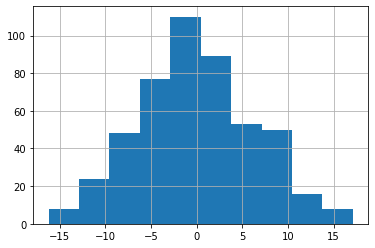

In [34]:
df_fda_percentage["well_being"].hist()

### Create 'well' variable

In [36]:
#Create a column if well_being > 0 --> 1
df_fda_wellness = df_fda_percentage.copy()
df_fda_wellness["well"] = 0
df_fda_wellness["well"].loc[df_fda_percentage['well_being'] > 0] = 1

In [37]:
df_fda_wellness.head()

,area_id,well_being,fat,fibre,carb,protein,saturate,weight_tot,percentage_fat,percentage_fibre,percentage_carb,percentage_protein,percentage_saturate,score,well
0,E05000026,0.699065,9.488797,1.564721,19.381951,4.977560,3.693721,30.435469,0.311768,0.051411,0.636821,0.163545,0.121362,0.979716,1
1,E05000027,-8.902220,9.733634,1.581960,18.950348,5.211694,3.565913,30.265942,0.321604,0.052269,0.626128,0.172197,0.117819,0.978299,0
2,E05000028,-10.425686,9.216310,1.572323,19.662048,5.192412,3.613582,30.450681,0.302663,0.051635,0.645701,0.170519,0.118670,0.983060,0
3,E05000029,-8.457127,9.700137,1.550344,20.084734,4.718184,3.961264,31.335215,0.309560,0.049476,0.640964,0.150571,0.126416,0.978490,0
4,E05000030,-7.604599,9.381808,1.607947,19.581403,5.307003,3.614663,30.571158,0.306884,0.052597,0.640519,0.173595,0.118238,0.982450,0


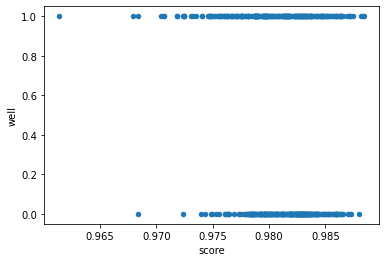

In [39]:
df_fda_wellness.plot(x='score', y='well', kind='scatter')

In [40]:
#Create a column for heathy dataset
df_healthy_well = df_healthy.copy()
df_healthy_well["well"] = 0
df_healthy_well["well"].loc[df_healthy['well_being'] > 0] = 1

In [41]:
df_healthy_well.head()

,area_id,well_being,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol,score,well
0,E05000026,0.699065,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364,0.125700,1
1,E05000027,-8.902220,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963,0.130958,0
2,E05000028,-10.425686,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,0.225425,...,0.006076,0.043609,0.009281,44.389378,11.114978,42.088964,1.562220,0.844460,0.138758,0
3,E05000029,-8.457127,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,0.200380,...,0.006578,0.046902,0.007344,45.759214,9.892203,42.109906,1.503467,0.735209,0.152978,0
4,E05000030,-7.604599,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,0.168952,...,0.006638,0.039688,0.009738,44.880395,11.283322,41.632398,1.575264,0.628621,0.139938,0


C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWar

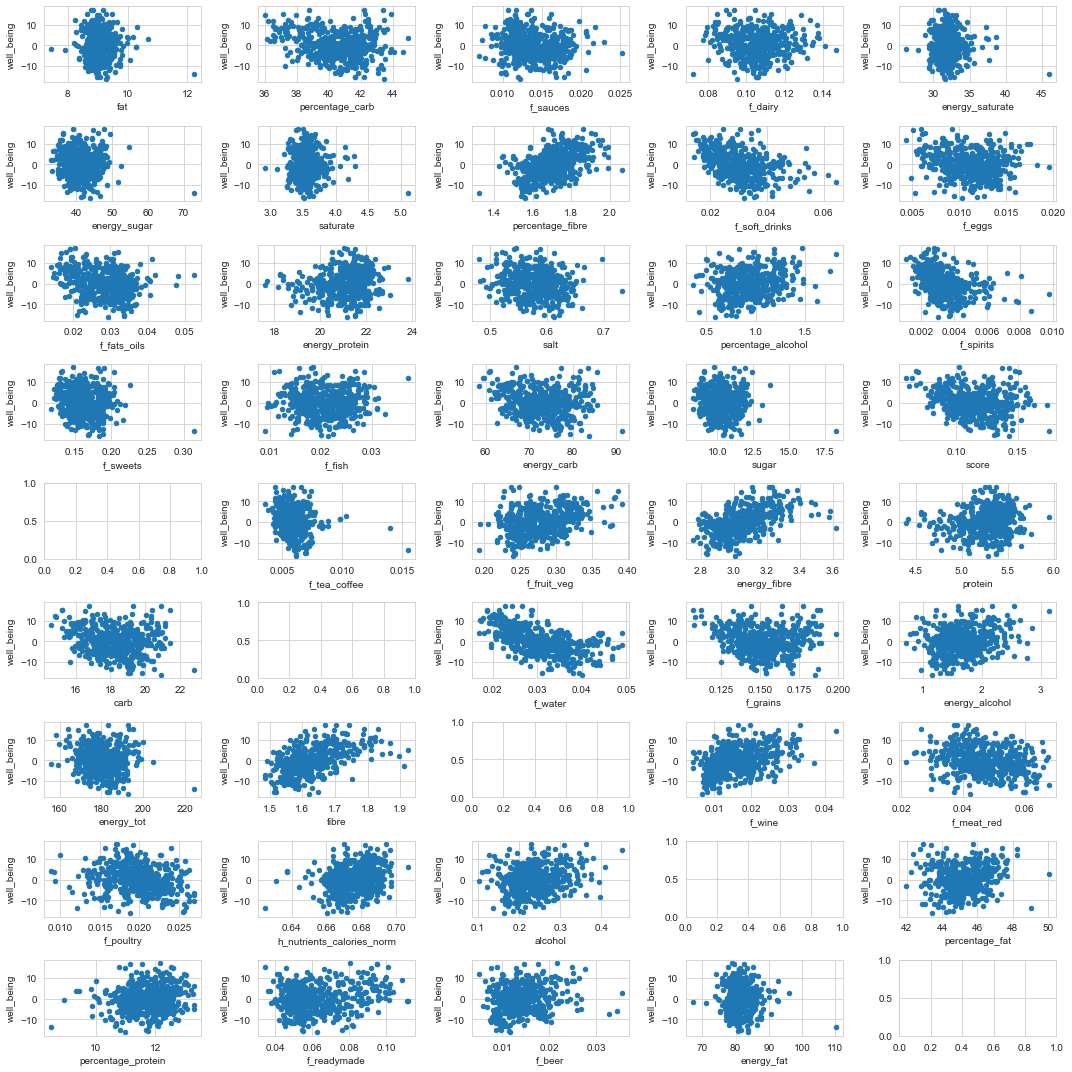

In [56]:

fig, axes = plt.subplots(nrows = 9, ncols=5, tight_layout=True, figsize=(15, 15))

for i, feature in enumerate(df_healthy_well.columns[2:-1]):
    df_healthy_well.plot(x=feature, y='well_being', kind='scatter', ax=axes[i%9][i%5])
    

In [73]:
df_fda_wellness.columns

Index(['area_id', 'well_being', 'fat', 'fibre', 'carb', 'protein', 'saturate',
       'weight_tot', 'percentage_fat', 'percentage_fibre', 'percentage_carb',
       'percentage_protein', 'percentage_saturate', 'score', 'well'],
      dtype='object')

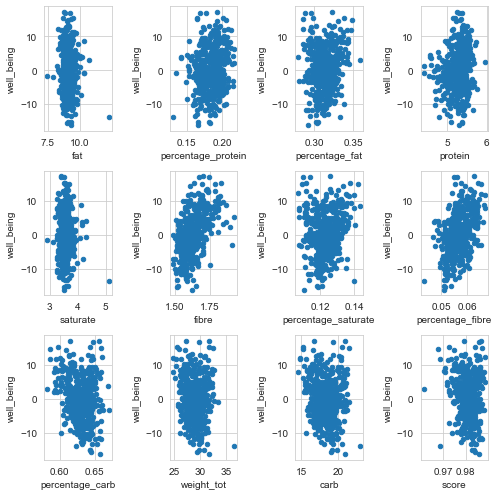

In [76]:

fig, axes = plt.subplots(nrows = 3, ncols=4, tight_layout=True, figsize=(7, 7))

for i, feature in enumerate(df_fda_wellness.columns[2:-1]):
    df_fda_wellness.plot(x=feature, y='well_being', kind='scatter', ax=axes[i%3][i%4])
    

## Classifier

In [59]:
df_train = df_fda_wellness.sample(frac=0.7)

X = df_fda_wellness[["score", "percentage_fat", "percentage_fibre", "percentage_carb", "percentage_protein", "percentage_saturate"]]
y = df_fda_wellness["well"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [60]:
# Use a Random Forest Classifier to predict labels
N_values  = np.array([int(i) for i in np.linspace(5.0, 200, 5)])
model     = RandomForestClassifier(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,
                                                   scoring='accuracy',
                                                   param_name = "n_estimators", 
                                                   param_range = N_values,
                                                   cv=cv_schema)

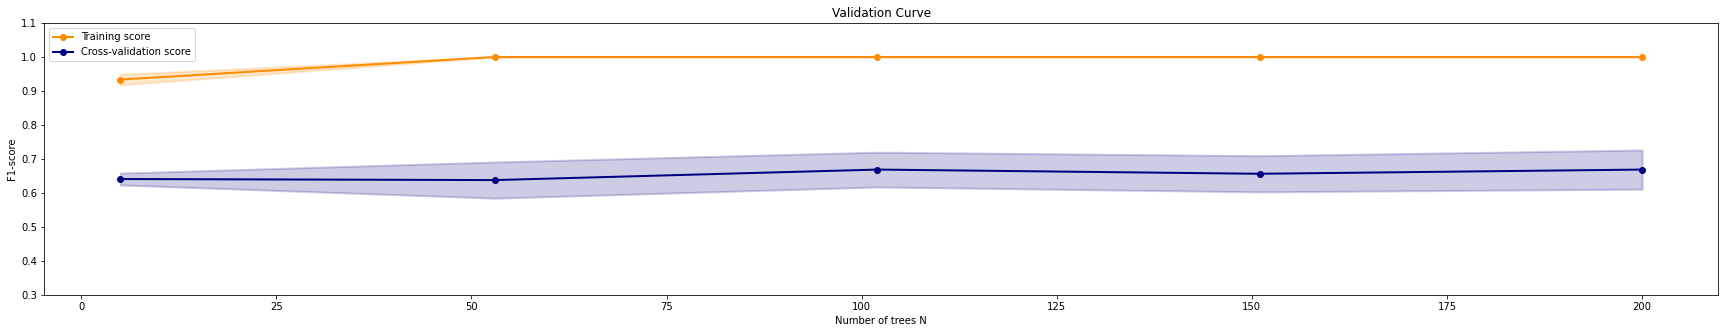

In [50]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores_val,
                      cv_scores_val,
                      N_values, y_label='F1-score',
                      ylim = [0.3, 1.1],
                      x_label='Number of trees N', 
                      x_logscale=False)


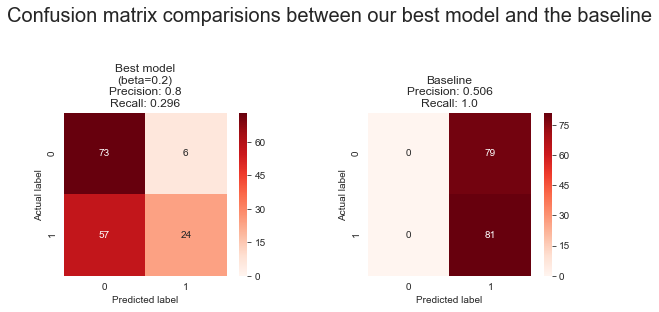

In [55]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
# Best random forest
best_thresh = 0.7755

RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat = RF.predict_proba(X_test)[:,1] > best_thresh
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Best model\n(beta=0.2)\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title, ax=axes[0])

# Baseline
y_hat_baseline = np.full_like(y_test, 1)
cm = confusion_matrix(y_test, y_hat_baseline)
precision = precision_score(y_test, y_hat_baseline)
recall = recall_score(y_test, y_hat_baseline)
title = "Baseline\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))

plot_confusion_matrix(cm, title=title, ax=axes[1])

plt.suptitle('Confusion matrix comparisions between our best model and the baseline', y=1.37, x=0.55, fontsize=20)

plt.show()

## Regression

In [63]:
# Fit logistic regression model to foods
mod = smf.ols(formula='well_being ~  f_beer + f_dairy + f_eggs + f_fats_oils+f_fish+f_fruit_veg+f_grains+f_meat_red+f_poultry+f_readymade + f_sauces+f_soft_drinks+f_spirits+f_sweets+f_tea_coffee+f_water+f_wine', data=df_healthy_well)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     24.80
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.74e-52
Time:                        17:29:45   Log-Likelihood:                -1422.1
No. Observations:                 483   AIC:                             2878.
Df Residuals:                     466   BIC:                             2949.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -50.6805     20.895     -2.426

In [65]:
mod = smf.ols(formula='well_being ~  f_fats_oils + f_fruit_veg + f_grains + f_readymade + f_soft_drinks + f_sweets + f_water + f_wine + f_sweets', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     46.82
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           2.29e-55
Time:                        17:30:34   Log-Likelihood:                -1430.2
No. Observations:                 483   AIC:                             2878.
Df Residuals:                     474   BIC:                             2916.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -91.0720     15.040     -6.055